In [52]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from pandas import DataFrame, read_csv
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Ejercicio 1
from redes import RedClassifier, RedRegressor
from espirales import generate_spirals_dataframe

# Ejercicio 5
from diagonal_paralelo import create_points_diagonal, create_points_paralelo

In [64]:
def plot_errors(ns: list[int], clfs: dict[int, RedClassifier | RedRegressor], title: str):
    clf_train_error = [clf.train_error for clf in clfs.values()]
    clf_val_error = [clf.val_error for clf in clfs.values()]
    clf_test_error = [clf.test_error for clf in clfs.values()]


    plt.plot(ns, clf_train_error, label="train", linestyle="--")
    plt.plot(ns, clf_val_error, label="validacion", linestyle="-.")
    plt.plot(ns, clf_test_error, label="test", linestyle="-")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_mse(ns: list[int], clf: RedClassifier | RedRegressor, title: str):
    plt.plot(ns, clf.train_errors, label="train", linestyle="--")
    if clf.val_errors != []: plt.plot(ns, clf.val_errors, label="validacion", linestyle="-.")
    plt.plot(ns, clf.test_errors, label="test", linestyle="-")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_error(ns: list[int], error: list[float], label: str, title: str):
    plt.plot(ns, error, label=label, linestyle="--")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_errors_compare(ns: list[int], error_train1: list[float], error_test1: list[float],
                        error_train2: list[float], error_test2: list[float], names: list[str]):
    plt.plot(ns, error_train1, 'cyan', label=f"{names[0]} train", linestyle="--")
    plt.plot(ns, error_test1, 'cyan', label=f"{names[0]} test", linestyle="-")
    plt.plot(ns, error_train2, 'magenta', label=f"{names[1]} train", linestyle="--")
    plt.plot(ns, error_test2, 'magenta', label=f"{names[1]} test", linestyle="-")
    plt.legend()
    plt.show()

# Ejercicio 1

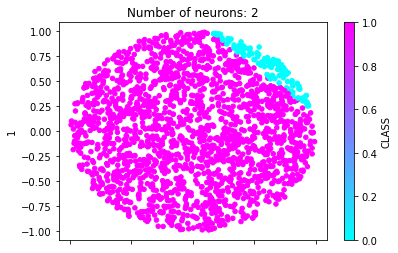

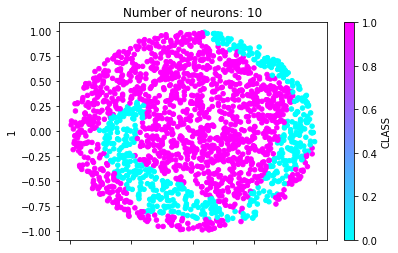

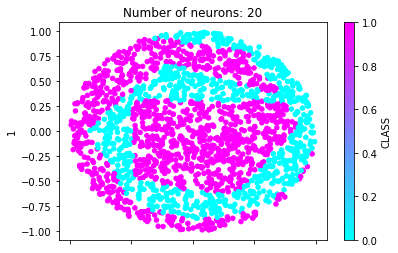

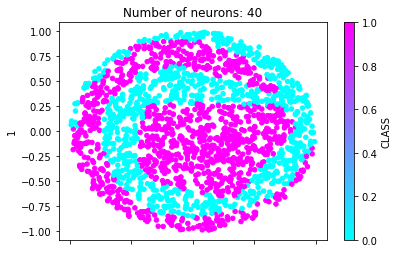

In [20]:
n_neurons = [2, 10, 20, 40]
ej1_df_data = generate_spirals_dataframe(600, 1)
ej1_df_test = generate_spirals_dataframe(2000, 1)

_x_train, _x_val, _y_train, _y_val = train_test_split(ej1_df_data.loc[:, [0, 1]],
                                                      ej1_df_data.loc[:, 'CLASS'],
                                                      test_size=.2,
                                                      random_state=0)

ej1_clfs: dict[int, RedClassifier] = {}

for n in n_neurons:
    cls = RedClassifier(N2=n, eta=0.1, alpha=0.9, time4training=20, eval_times=1000)
    cls.train(_x_train, _x_val, _y_train, _y_val)
    df_test = cls.predict(df_test=ej1_df_test.copy())
    df_test.plot(x=0, y=1, kind='scatter', c='CLASS', colormap='cool', title=f'Number of neurons: {n}')
    ej1_clfs[n] = cls
    cls.save(f'ejercicio-1/red-{n}.pkl')
    

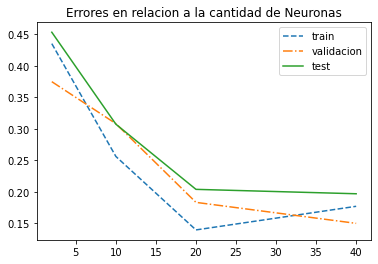

In [65]:
plot_errors(n_neurons, ej1_clfs, 'Errores en relacion a la cantidad de Neuronas')

# Conclusion
Como podemos ver en los primero plots, a medida que amuentamos la cantidad de neuronas de la capa intermedia, se nota una mejoria en la clasificacion de puntos.

Tambien se puede ver que a diferencia del TP anterior, con redes neuronales, los cortes que hace el modelo es mas acorde a la realidad (con arboles, los cortes eran mas rectos)

Por ultimo, podemos ver que el error de train y test no estan muy lejos entre si y podemos decir que convergen a un valor cercano a 0.2 aproximadamente. Salvo en el en el caso de 20 neuronas, los errores de test y train no estaban tan separados, por lo que no se produjo mucho sobreajuste.

# Ejercicio 2

In [22]:
alpha_vals = [0, 0.5, 0.9]
eta_vals = [0.1, 0.01, 0.001]
permutations = [(alpha, eta) for alpha in alpha_vals for eta in eta_vals]


ej2_df_data = read_csv('dos_elipses/dos_elipses.data', names=[0, 1, 'CLASS'])
ej2_df_data = ej2_df_data.sample(500)
ej2_df_test = read_csv('dos_elipses/dos_elipses.test', names=[0, 1, 'CLASS'])

_x_train, _x_val, _y_train, _y_val = train_test_split(ej2_df_data.loc[:, [0, 1]],
                                                      ej2_df_data.loc[:, 'CLASS'],
                                                      test_size=.2,
                                                      random_state=0)

ej2_clfs: dict[str, RedClassifier] = {'best': None, 'tmp': None}
ej2_test_errors = []

for alpha, eta in permutations:
    _train_errors = 0
    _val_errors = 0
    _test_errors = 0
    tmp: RedClassifier = None
    
    for _ in range(10):
        cls = RedClassifier(N2=6, eta=eta, alpha=alpha, time4training=50, eval_times=300)
        cls.train_val_predict(_x_train, _x_val, _y_train, _y_val, ej2_df_test.copy())
        _train_errors += cls.train_error
        _val_errors += cls.val_error
        _test_errors += cls.test_error

        if not tmp or cls.test_error < tmp.test_error:
            tmp = cls
    
    ej2_clfs[f'{alpha}-{eta}'] = tmp

    if not ej2_clfs['best'] or ej2_clfs[f'{alpha}-{eta}'].test_error < ej2_clfs['best'].test_error:
        ej2_clfs['best'] = ej2_clfs[f'{alpha}-{eta}']

    ej2_test_errors.append(_test_errors/10)

ej2_clfs['best'].save('ejercicio-2/red-best.pkl')

ej2_info = DataFrame({'Alpha': [alpha for alpha, _ in permutations],
                      'Eta': [eta for _, eta in permutations],
                      'Test Error': ej2_test_errors})
ej2_info


,Alpha,Eta,Test Error
0,0.0,0.100,0.11305
1,0.0,0.010,0.22135
2,0.0,0.001,0.24350
3,0.5,0.100,0.03755
4,0.5,0.010,0.18690
5,0.5,0.001,0.23815
6,0.9,0.100,0.05990
7,0.9,0.010,0.09560
8,0.9,0.001,0.21545


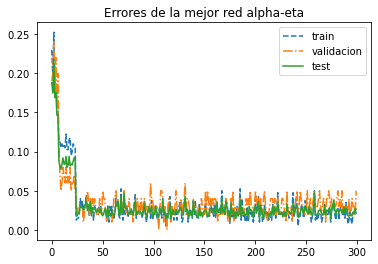

In [66]:
plot_mse(range(300), ej2_clfs['best'], 'Errores de la mejor red alpha-eta')

# Conclusion
Con la tabla podemos ver lo bajo que es el error de test con algunas combinaciones de los valores de `alpha` y `eta`. Por ejemplo con los valores `alpha=.5` y `eta=.1` encontramos el menor error de test (0.03755). Con estos valores podemos formar el mejor modelo para este problema.

El grafico muestra como fue el proceso de entrenamiento de la mejor red, podemos ver que con los primeros entrenamientos disminuye mucho los errores y luego converge a un valor cercano/menor a 0.05 el cual es muy bajo

# Ejercicio 3

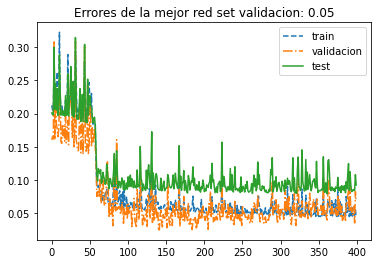

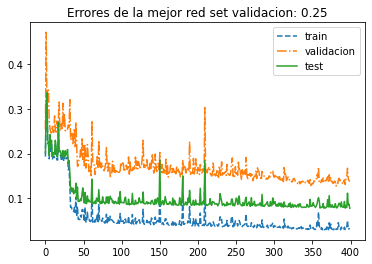

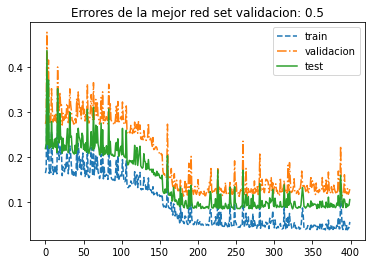

In [94]:
val_percentages = [.05, .25, .5]

ej3_df_data = read_csv('ikeda/ikeda.data', names=[0,1,2,3,4,'CLASS'], delim_whitespace=True)
ej3_df_test = read_csv('ikeda/ikeda.test', names=[0,1,2,3,4,'CLASS'], delim_whitespace=True).sample(2000)

ej3_clfs: dict[float, RedRegressor] = {}

for val in val_percentages:
    _x_train, _x_val, _y_train, _y_val = train_test_split(ej3_df_data.loc[:, range(5)],
                                                          ej3_df_data.loc[:, 'CLASS'],
                                                          test_size=val,
                                                          random_state=0)
    clf = RedRegressor(N2=30, eta=.01, alpha=.9, time4training=50, eval_times=400)
    clf.train_val_predict(_x_train, _x_val, _y_train, _y_val, ej3_df_test.copy())
    ej3_clfs[val] = clf
    clf.save(f'ejercicio-3/red-{val}.pkl')
    plot_mse(range(400), clf, f'Errores de la mejor red set validacion: {val}')

# Conclusion
Lo poco que podemos concluir en este ejercicio es que a medida que aumentamos el conjunto de validacion, al comienzo del entrenamiento los errores toman valores mayores. Con un conjunto del 5% del data set, los errores no superean los 0.3 y en los otros casos si. En mi opinion esto pasa porque no le estamos dando mucha cantidad de datos de entrenamientos para entrenar bien a nuesto modelo porque le estamos sacando un porcentaje grande de datos para usarlos para validar.

Tambien podemos ver que en los ultimos 2 graficos, los errores convergen a un valor entre 0.5 y 1.5, y en el primer grafico, los errores convergen a un valor cercano a 0.5

# Ejercicio 4

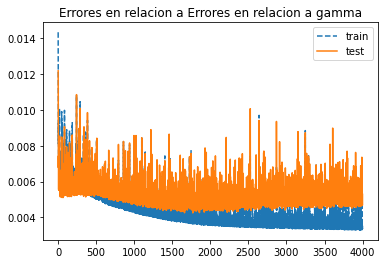

In [25]:
gammas = [10**(-(i+1)) for i in range(6)]

_names = list(range(12))+['CLASS']
ej4_df_data = read_csv('ssp/ssp.data', names=_names)
ej4_df_test = read_csv('ssp/ssp.test', names=_names)

_x_train, _y_train = ej4_df_data.loc[:, range(12)], ej4_df_data.loc[:, 'CLASS']

ej4_clfs: dict[str, RedRegressor] = {'best': None}

for gamma in gammas:
    clf = RedRegressor(N2=6, eta=.05, alpha=.3, time4training=20, eval_times=4000, gamma=gamma)
    clf.train_predict(_x_train, _y_train, ej4_df_test.copy())
    clf.save(f'ejercicio-4/red-{gamma}.pkl')
    if not ej4_clfs['best'] or clf.test_error < ej4_clfs['best'].test_error:
        ej4_clfs['best'] = clf
    ej4_clfs[f'{val}'] = clf

ej4_clfs['best'].save('ejercicio-4/red-best.pkl')

plot_mse(range(4000), ej4_clfs['best'], 'Errores en relacion a gamma')

# Conclusion
Podemos ver que a lo largo del entrenamiento, los errores se empiezan a distanciar y podemos decir que al final tenemos un poco de sobreajuste ya que el error de train es menor al error de test.

Tambien podemos decir que los errores son bastante bajos y el modelo es bueno para utilizar

# Ejercicio 5

In [ ]:
d_vals = [2, 4, 8, 16, 32]

ej5_diag_clfs: dict[str, RedClassifier] = {'best': None}
ej5_paral_clfs: dict[str, RedClassifier] = {'best': None}
ej5_diag_train_errors = []
ej5_diag_test_errors = []
ej5_paral_train_errors = []
ej5_paral_test_errors = []

for d in d_vals:
    df_test = create_points_diagonal(d, 10000, .78)
    tmp: RedClassifier
    _train_errors = 0
    _test_errors = 0

    for i in range(20):
        df_data = create_points_diagonal(d, 250, .78)
        clf = RedClassifier(N2=6, eta=.1, alpha=.5, time4training=50, eval_times=300, gamma=(10**-5))
        clf.train_predict(df_data.loc[:, range(d)], df_data.loc[:, 'CLASS'], df_test)
        _train_errors += clf.train_error
        _test_errors += clf.test_error

        if not tmp or clf.test_error < tmp.test_error:
            tmp = clf
    
    ej5_diag_clfs[f'{d}'] = tmp
    ej5_diag_train_errors.append(_train_errors/20)
    ej5_diag_test_errors.append(_test_errors/20)
    tmp.save(f'ejercicio-5/red-diag-{d}.pkl')
    
    if not ej5_diag_clfs['best'] or tmp.test_error < ej5_diag_clfs['best'].test_error:
        ej5_diag_clfs['best'] = tmp
    

for d in d_vals:
    df_test = create_points_paralelo(d, 10000, .78)
    tmp: RedClassifier
    _train_errors = 0
    _test_errors = 0

    for i in range(20):
        df_data = create_points_paralelo(d, 250, .78)
        clf = RedClassifier(N2=6, eta=.1, alpha=.5, time4training=50, eval_times=300, gamma=(10**-5))
        clf.train_predict(df_data.loc[:, range(d)], df_data.loc[:, 'CLASS'], df_test)
        _train_errors += clf.train_error
        _test_errors += clf.test_error

        if not tmp or clf.test_error < tmp.test_error:
            tmp = clf
    
    ej5_paral_clfs[f'{d}'] = tmp
    ej5_paral_train_errors.append(_train_errors/20)
    ej5_paral_test_errors.append(_test_errors/20)
    tmp.save(f'ejercicio-5/red-paral-{d}.pkl')

    if not ej5_paral_clfs['best'] or tmp.test_error < ej5_paral_clfs['best'].test_error:
        ej5_paral_clfs['best'] = tmp

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Datos Diagonal

d_vals = [2, 4, 8, 16, 32]

tree_diag_error_train = []
tree_diag_error_test = []

for d in d_vals:
    df_test = create_points_diagonal(d, 10000, .78)

    error_train_ = 0
    error_test_ = 0
    for _ in range(20):
        df_train = create_points_diagonal(d, 250, .78)

        clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
        clf.fit(df_train.loc[:,range(d)], df_train.loc[:,"CLASS"])

        error_train_ += (1-accuracy_score(df_train.loc[:,"CLASS"], clf.predict(df_train.loc[:,range(d)])))
        
        pred = clf.predict(df_test.loc[:,range(d)])
        error_test_ += (1-accuracy_score(df_test.loc[:,"CLASS"], pred))
    
    # Calculamos mean de cada valor
    tree_diag_error_train.append(error_train_/20)
    tree_diag_error_test.append(error_test_/20)

tree_paral_error_train = []
tree_paral_error_test = []

for d in d_vals:
    df_test = create_points_paralelo(d, 10000, .78)

    error_train_ = 0
    error_test_ = 0
    for _ in range(20):
        df_train = create_points_paralelo(d, 250, .78)

        clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
        clf.fit(df_train.loc[:,range(d)], df_train.loc[:,"CLASS"])

        error_train_ += (1-accuracy_score(df_train.loc[:,"CLASS"], clf.predict(df_train.loc[:,range(d)])))
        
        pred = clf.predict(df_test.loc[:,range(d)])
        error_test_ += (1-accuracy_score(df_test.loc[:,"CLASS"], pred))

    
    # Calculamos mean de cada valor
    tree_paral_error_train.append(error_train_/20)
    tree_paral_error_test.append(error_test_/20)

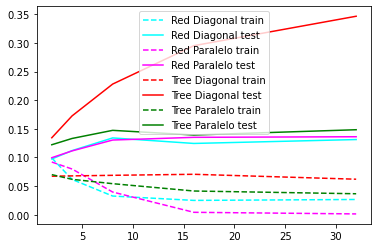

In [38]:
plt.plot(d_vals, ej5_diag_train_errors, 'cyan', label="Red Diagonal train", linestyle="--")
plt.plot(d_vals, ej5_diag_test_errors, 'cyan', label="Red Diagonal test", linestyle="-")
plt.plot(d_vals, ej5_paral_train_errors, 'magenta', label="Red Paralelo train", linestyle="--")
plt.plot(d_vals, ej5_paral_test_errors, 'magenta', label="Red Paralelo test", linestyle="-")
plt.plot(d_vals, tree_diag_error_train, 'red', label="Tree Diagonal train", linestyle="--")
plt.plot(d_vals, tree_diag_error_test, 'red', label="Tree Diagonal test", linestyle="-")
plt.plot(d_vals, tree_paral_error_train, 'green', label="Tree Paralelo train", linestyle="--")
plt.plot(d_vals, tree_paral_error_test, 'green', label="Tree Paralelo test", linestyle="-")
plt.legend()
plt.show()

# Conclusion
En este grafico podemos ver que las redes se comportan de forma similar a los arboles en el sentido de que si amumentamos las dimensiones, los errores de test aumentan. Podemos ver que con 2 dimensiones, los errores convergen a un valor entre 0.10 y 0.15.

Luego se puede destacar que en el casos de las redes, los errores de test son casi similares, que a diferencia de los arboles, el error de test del problema Diagonal es bastante mayor al problema Paralelo.

# Ejercicio 6

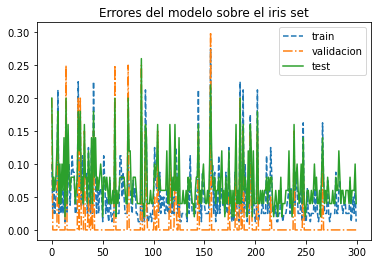

In [74]:
from sklearn.datasets import load_iris

iris = load_iris()
_x = iris.data
_y = iris.target
_x_data, _x_test, _y_data, _y_test = train_test_split(_x, _y, test_size=.33, random_state=0)
_x_train, _x_val, _y_train, _y_val = train_test_split(_x_data, _y_data, test_size=.2, random_state=0)
ej6_iris_df_test = DataFrame(_x_test)
ej6_iris_df_test['CLASS'] = _y_test

ej6_iris_clf = RedClassifier(6, eta=.1, alpha=.5, time4training=50, eval_times=300, gamma=(10**-5))
ej6_iris_clf.train_val_predict(_x_train, _x_val, _y_train, _y_val, ej6_iris_df_test.copy())

plot_mse(range(300), ej6_iris_clf, 'Errores del modelo sobre el iris set')


# Conclusion
En este ejercicio es bastante complicado concluir de este grafico ya que ocila bastante pero parece que los errores de train y test son similares. En la mayoria del entrenamiento, los errores toman valores entre 0.05 y 0.1 (lo cual es bajo).

Tambien podemos concluir que los errores son bastantes bajo y podemos decir que el modelo entrenado es bueno y lo podriamos utilizar

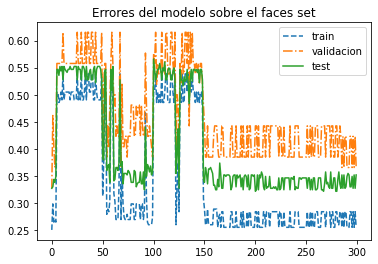

In [95]:
_names = list(range(960))+['CLASS']
ej6_faces_df_data = read_csv('faces/faces.data', names=_names)
ej6_faces_df_test = read_csv('faces/faces.test', names=_names)
_y = ej6_faces_df_data.loc[:, 'CLASS']
ej6_faces_df_data = (ej6_faces_df_data - np.min(ej6_faces_df_data)) / (np.max(ej6_faces_df_data) - np.min(ej6_faces_df_data))
ej6_faces_df_data['CLASS'] = _y
_y = ej6_faces_df_test.loc[:, 'CLASS']
ej6_faces_df_test = (ej6_faces_df_test - np.min(ej6_faces_df_test)) / (np.max(ej6_faces_df_test) - np.min(ej6_faces_df_test))
ej6_faces_df_test['CLASS'] = _y



_x_train, _x_val, _y_train, _y_val = train_test_split(ej6_faces_df_data.loc[:, range(960)],
                                                      ej6_faces_df_data.loc[:, 'CLASS'],
                                                      test_size=.2,
                                                      random_state=0)
ej6_faces_clf = RedClassifier(6, eta=.1, alpha=.5, time4training=50, eval_times=300)
ej6_faces_clf.train_val_predict(_x_train, _x_val, _y_train, _y_val, ej6_faces_df_test.copy())

plot_mse(range(300), ej6_faces_clf, 'Errores del modelo sobre el faces set')

# Ejercicio 7

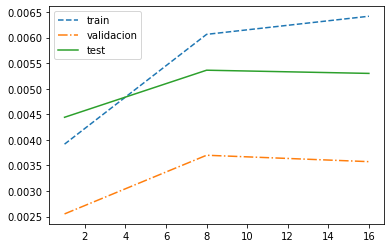

In [92]:
def entrenar_eje7(s_batch: float, x_train: DataFrame, x_val: DataFrame,
                  y_train: DataFrame, y_val: DataFrame,
                  df_test: DataFrame):
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_squared_error
    from copy import deepcopy

    net = MLPRegressor(hidden_layer_sizes=(6,),
                            activation='logistic',
                            solver='sgd', alpha=0.0,
                            batch_size=s_batch, learning_rate='constant',
                            learning_rate_init=.05,momentum=.3,
                            nesterovs_momentum=False,tol=0.0,
                            warm_start=True,
                            max_iter=200)
    best: MLPRegressor = None
    best_train_error: float = None
    best_val_error: float = None
    best_test_error: float = None

    for _ in range(2000):
        net.fit(x_train, y_train)

        pred_train = net.predict(x_train)
        pred_val = net.predict(x_val)
        pred_test = net.predict(df_test.loc[:, range(len(df_test.columns)-1)])

        train_error = mean_squared_error(y_train, pred_train)
        val_error = mean_squared_error(y_val, pred_val)
        test_error = mean_squared_error(df_test.loc[:, 'CLASS'], pred_test)

        if not best_val_error or val_error < best_val_error:
            best = deepcopy(net)
            best_train_error = train_error
            best_val_error = val_error
            best_test_error = test_error
        
    return best, best_train_error, best_val_error, best_test_error

_names = list(range(12))+['CLASS']
ej7_df_data = read_csv('ssp/ssp.data', names=_names)
ej7_df_test = read_csv('ssp/ssp.test', names=_names)

_x_train, _x_val, _y_train, _y_val = train_test_split(ej7_df_data.loc[:, range(12)],
                                                      ej7_df_data.loc[:, 'CLASS'],
                                                      test_size=.2,
                                                      random_state=0)
batch_vals = [1, 8, 16]
ej7_train_errors = []
ej7_val_errors = []
ej7_test_errors = []

for batch in batch_vals:
    _, _train_error, _val_error, _test_error = entrenar_eje7(batch, _x_train, _x_val, _y_train, _y_val, ej7_df_test.copy())
    ej7_train_errors.append(_train_error)
    ej7_val_errors.append(_val_error)
    ej7_test_errors.append(_test_error)

plt.plot(batch_vals, ej7_train_errors, label="train", linestyle="--")
plt.plot(batch_vals, ej7_val_errors, label="validacion", linestyle="-.")
plt.plot(batch_vals, ej7_test_errors, label="test", linestyle="-")
plt.legend()
plt.show()

# Conclusion
Se puede notar que los errores son bastantes bajos por lo tanto nuestro modelo es bastante bueno.

A medida que aumentamos nuestro valor de `batch` se puede ver como los errores aumenta un poco pero no se produce sobreajuste ya que el error de test es menor al error de train. Ademas, cuando aumentamos el `batch`, el error tiende al un valor cercano a 0.005